In [1]:
#import probably useful packages... 
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pynbody
import pynbody.plot.sph as sph
import re
import scipy.signal
import scipy.interpolate
import struct
import sys
import h5py

In [2]:
#ALWAYS REMEMBER TO HAVE A .param FILE IN YOUR WORKING DIRECTORY
#if you don't have one it doesn't know the units and you will get wrong results

params = {"font.family":"serif","mathtext.fontset":"stix"}
matplotlib.rcParams.update(params)

#for your information, these are old unit conversions if not using pynbody package.
# actually it's okay to delete these but I keep them just in case...
kpc_cgs= 3.08567758e21
G_cgs  = 6.67e-8
Mo_cgs = 1.99e33
umass_GizToGas = 1. #1e9Mo
umass = 1.0 #* umass_GizToGas
udist = 1.0  #kpc
uvel  = np.sqrt( G_cgs * umass * Mo_cgs / (udist * kpc_cgs) )/1e5
#uvel = 207.402593435
udens = umass * Mo_cgs / (udist * kpc_cgs)**3.
utime = np.sqrt(1./(udens * G_cgs))
sec2myr = 60.*60.*24.*365.*1e6

In [3]:
#Need to insert your filepath here + start of filename ie. ~/GLX.00
# make sure the number of zeros is correct for the snap you're loading
filepth = '/Users/eile0750/Desktop/Work/Sims_snap1000/IsoB_1000/GLX.0'
timestep = (['1000'])

In [7]:
#Here, we now must load the snapshot we want by following the filepath and time above
i=0
#while i<len(timestep): #if wanting to run sequentially over multiple timesteps
filenom = (filepth+timestep[i])
dno = timestep[i]
s    = pynbody.load(filenom) 
s.physical_units()

#The simulation has been read by pynbody. Now, let's learn about what's inside it. 
print ('-------PREAMBLE-------')
print (s.families()) #gives you an output that tells you what components you have in the simulation
#print (s.properties)
print (s.g) #gives you an output that tells you the number of gas particles len=?
print (s.gas.loadable_keys()) #uncomment for list of parameters about gas that are in the data
#print (s.gas.derivable_keys()) #uncomment for list of parameters " that can be derived from the data
print (s.s) #gives you an output that tells you the number of gas particles len=?
#print (s.star.loadable_keys()) #uncomment for list of parameters about stars that are in the data
#print (s.star.derivable_keys()) #uncomment for list of parameters " that can be derived from the data
print (s.dm) #gives you an output that tells you the number of gas particles len=?
#print (s.dm.loadable_keys()) #uncomment for list of parameters about dark matter that are in the data

#these lines about time mean you can put a snap time on your plots later... 
t_now =  s.properties['time'].in_units('Myr')
timestr = str( np.round(float(t_now),1) )

-------PREAMBLE-------
[<Family gas>, <Family dm>, <Family star>]
<FamilySubSnap "/Users/eile0750/Desktop/Work/Sims_snap1000/IsoB_1000/GLX.01000::gas" len=2394052>
['', 'OxMassFrac', 'phi', 'temp', 'Tinc', 'tempEff', 'FeMassFrac', 'massHot', 'eps', 'u', 'pos', 'HI', 'HeI', 'vel', 'timeform', 'mass', 'uDotFB', 'iord', 'HeII', 'metals', 'rho', 'massform', 'MassHot', 'igasorder', 'uHot']
<FamilySubSnap "/Users/eile0750/Desktop/Work/Sims_snap1000/IsoB_1000/GLX.01000::star" len=4666410>
<FamilySubSnap "/Users/eile0750/Desktop/Work/Sims_snap1000/IsoB_1000/GLX.01000::dm" len=1000000>


In [5]:
#Now, let's set up for any analysis we want to do...

#Put CoM in middle
pynbody.analysis.angmom.faceon(s)
#pynbody.analysis.angmom.sideon(s)

#Rotate if we want
#s.rotate_y(45)
#s.rotate_x(40)
#s.rotate_z(20)

#Some possibly useful filters:
#agefilt = pynbody.filt.BandPass('age','200 Myr','1000 Myr')
#sphere  = pynbody.filt.Sphere('10 kpc')

#Bin stuff up radially for nice profiles:
r_enc = '15 kpc'
pp  = pynbody.analysis.profile.Profile(s,max=r_enc,min='0.01 kpc',type='log',nbins=300)
ppd = pynbody.analysis.profile.Profile(s.dm,max=r_enc,min='0.01 kpc',type='log',nbins=300)
ppg = pynbody.analysis.profile.Profile(s.gas,max=r_enc,min='0.01 kpc',type='log',nbins=300)
pps = pynbody.analysis.profile.Profile(s.stars,max=r_enc,min='0.01 kpc',type='log',nbins=300)

print ('------SETUP-DONE------')

------SETUP-DONE------


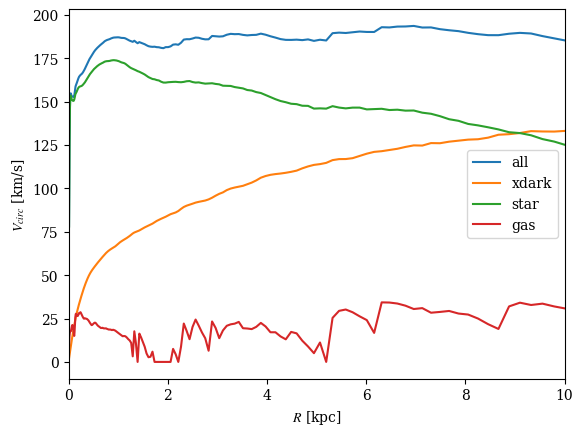

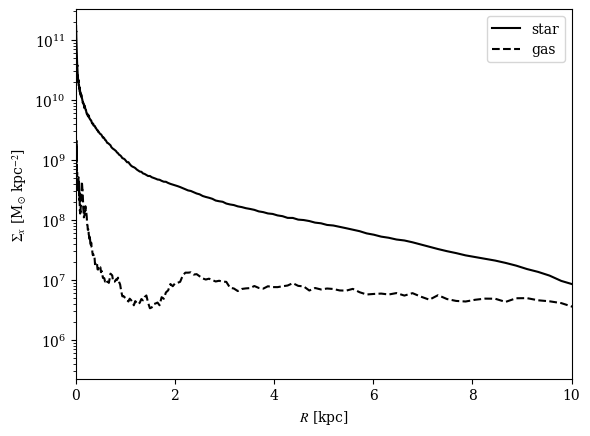

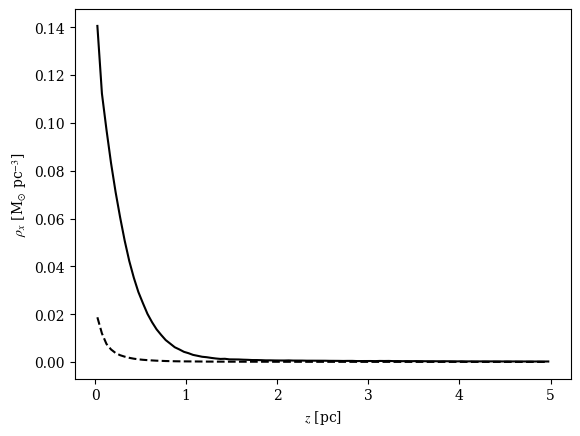

plotting stars


<Figure size 640x480 with 0 Axes>

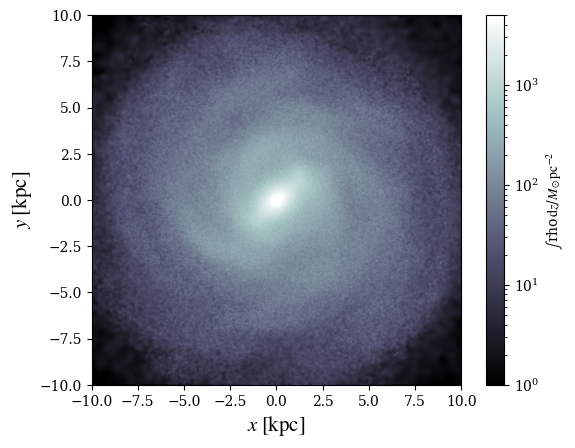

plotting gas


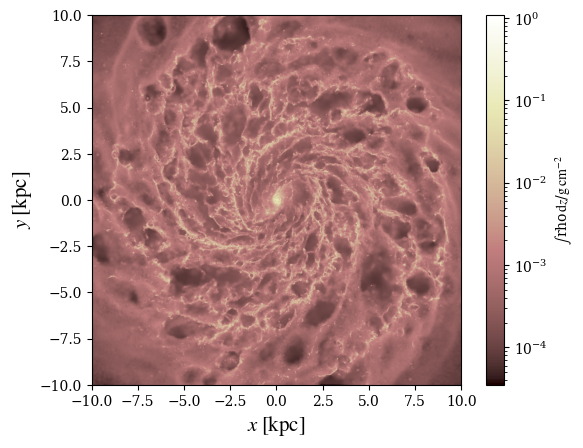

plotting DM


<Figure size 640x480 with 0 Axes>

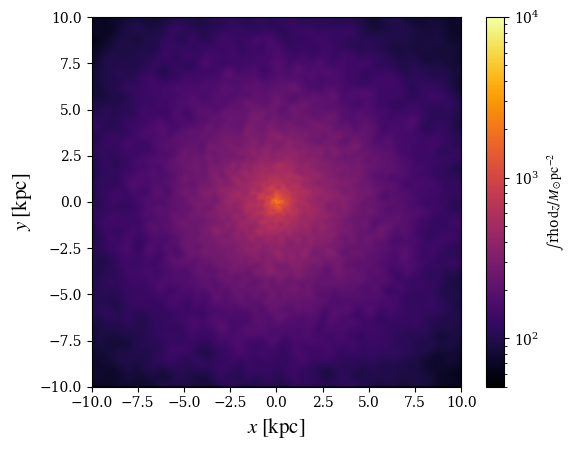

plotting extra plots
Star Vr


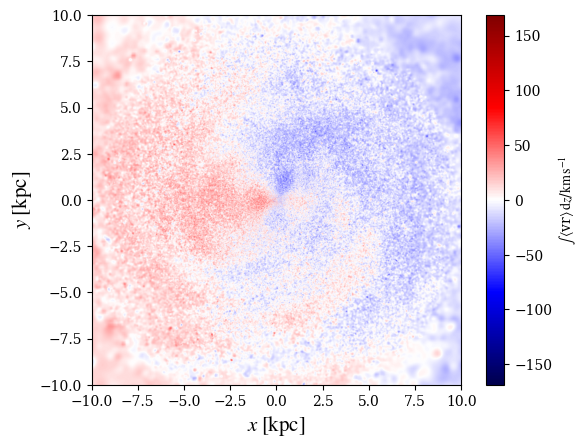

Star Vt


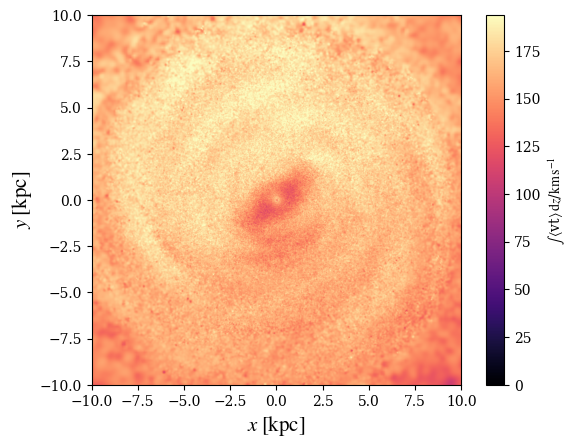

Star Zmetal


<Figure size 640x480 with 0 Axes>

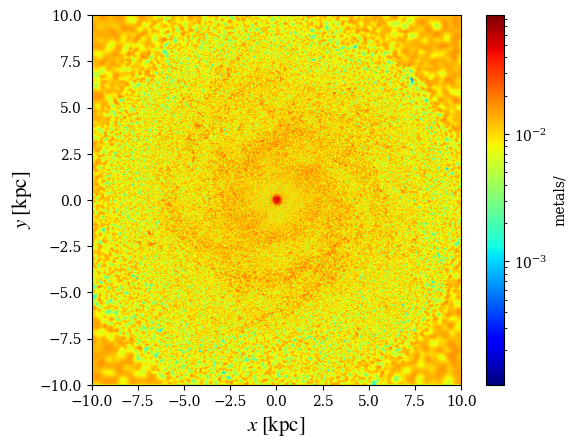

Gas Vr


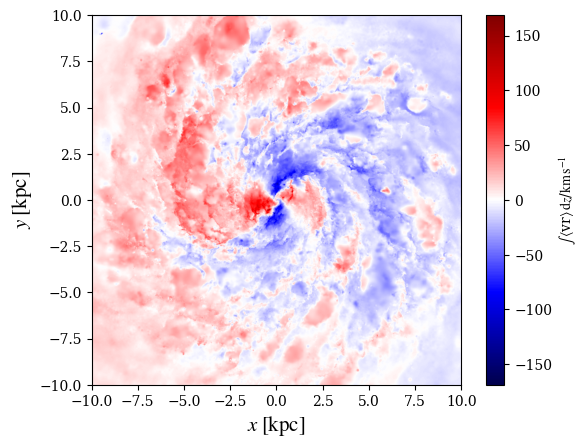

Gas Vt


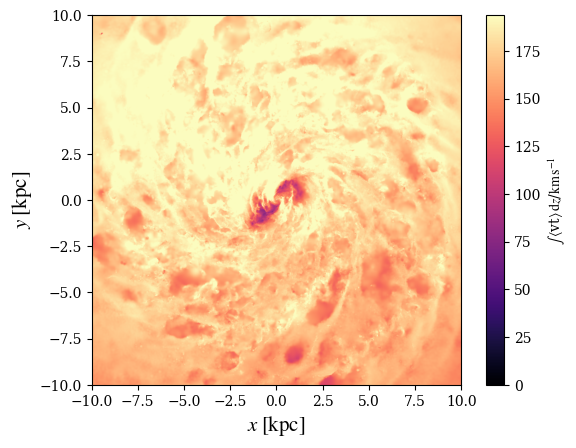

In [6]:
#Some useful plots using pynbody

# Rotation curve 
plt.clf()
#plt.plot(p['rbins'],label='mod')
plt.plot(pp['rbins'],pp['v_circ'],label='all')
plt.plot(ppd['rbins'],ppd['v_circ'],label='xdark')
plt.plot(pps['rbins'],pps['v_circ'],label='star')
plt.plot(ppg['rbins'],ppg['v_circ'],label='gas')
plt.legend()
plt.xlim(0,10)
plt.xlabel('$R$ [kpc]')
plt.ylabel('$V_{circ}$ [km/s]')
plt.show()

# Density Profile
plt.clf()
#plt.plot(p['rbins'],label='mod')
plt.plot(pps['rbins'],pps['density'].in_units('Msol kpc^-2'),'k',label='star')
plt.plot(ppg['rbins'],ppg['density'].in_units('Msol kpc^-2'),'k--',label='gas')
plt.legend()
plt.xlim(0,10)
plt.xlabel('$R$ [kpc]')
plt.ylabel(r'$\Sigma_{x}$ [M$_{\odot}$ kpc$^{-2}$]')
plt.semilogy()
plt.show()

ps_vert = pynbody.analysis.profile.VerticalProfile( s.stars, '0 kpc', '15 kpc', '5 kpc')
pg_vert = pynbody.analysis.profile.VerticalProfile( s.gas, '0 kpc', '15 kpc', '5 kpc')

plt.clf()
plt.plot(ps_vert['rbins'].in_units('kpc'), ps_vert['density'].in_units('Msol pc^-3'),'k')
plt.plot(pg_vert['rbins'].in_units('kpc'), pg_vert['density'].in_units('Msol pc^-3'),'k--')
plt.xlabel('$z$ [pc]') 
plt.ylabel(r'$\rho_{x}$ [M$_{\odot}$ pc$^{-3}$]')
plt.show()

    
#-- Face-on stellar density plot
print ('plotting stars')
vmin=1e0
vmax=5e3
plt.clf()
figS = plt.figure(2)
axS=figS.add_subplot(1,1,1)
im_S = sph.image(s.star,qty='rho',width='20 kpc',units='Msol pc^-2',cmap='bone',subplot=axS,vmin=vmin,vmax=vmax,show_cbar = True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axS.annotate(timestr+'Myr',xy=(0.7,0.9),xycoords='axes fraction',color='white',fontsize=13)
#plt.ylim(-3.5,3.5)
plt.show()
#plt.savefig('StarPrj1_'+str(dno)) 

#-- Face-on gas density plot
print ('plotting gas')
#vmin=3e-4
#vmax=8e-2
plt.clf()
figG=plt.figure(1)
axG=figG.add_subplot(1,1,1)
imG=sph.image(s.gas,qty='rho',width='20 kpc',cmap='pink',units='g cm^-2',subplot=axG,show_cbar=True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
#plt.ylim(-3.5,3.5)
axG.annotate(timestr+'Myr',xy=(0.7,0.9),xycoords='axes fraction',color='white',fontsize=13)
plt.show()
#plt.savefig('GasPrj1_'+str(dno))

#-- Face-on DM density plot
print ('plotting DM')
vmin=5e1
vmax=1e4
plt.clf()
figD=plt.figure(3)
axD=figD.add_subplot(1,1,1)
im_D=sph.image(s.dm,qty='rho',width='20 kpc',cmap='inferno',units='Msol pc^-2',subplot=axD,vmin=vmin,vmax=vmax,show_cbar=True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axD.annotate(timestr+'Myr',xy=(0.7,0.9),xycoords='axes fraction',color='white',fontsize=13)
plt.show()
#plt.savefig('DMPrj1_'+str(dno))

print ('plotting extra plots')
res= 1500
aza = 'rho'    #uses a column average

## Star extra plots

#-- Face-on projection of Radial velocity (v_R)
print ('Star Vr')
plt.clf()
vmin= -np.max(pp['v_circ'])+25
vmax= np.max(pp['v_circ'])-25
#vmin=vmin,vmax=vmax,
figVr=plt.figure(1)
axVr=figVr.add_subplot(1,1,1)
im=sph.image(s.star,qty='vr',width='20 kpc',cmap='seismic',resolution=res,vmin=vmin,vmax=vmax,log=False,units='km s^-1',av_z=aza,show_cbar = True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axVr.annotate(timestr+'Myr',xy=(0.5,0.5),xycoords='axes fraction',color='black',fontsize=13)
#plt.ylim(-3.5,3.5)
plt.xlim(-10,10)
plt.show()
#plt.savefig('vr.png')

#-- Face-on projection of Tangential velocity (v_t)
print ('Star Vt')
plt.clf()
vmin= 0
vmax= np.max(pp['v_circ'])
#vmin=vmin,vmax=vmax
figVt=plt.figure(1)
axVt=figVt.add_subplot(1,1,1)
sph.image(s.star,qty='vt',width='20 kpc',cmap='magma',show_cbar = True,vmin=vmin,vmax=vmax,resolution=res,log=False,units='km s^-1',av_z=aza)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axVt.annotate(timestr+'Myr',xy=(1.7,1.9),xycoords='axes fraction',color='white',fontsize=13)
plt.ylim(-10,10)
#plt.ylim(-3.5,3.5)
plt.xlim(-10,10)
plt.show()
#plt.savefig('vt.png')

#-- Face-on projection of Metallicity (Zmetal)
print ('Star Zmetal')
plt.clf()
figS = plt.figure(2)
axS=figS.add_subplot(1,1,1)
im_S = sph.image(s.star,qty='metals',width='20 kpc',cmap='jet',subplot=axS,show_cbar = True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axS.annotate(timestr+'Myr',xy=(0.7,0.9),xycoords='axes fraction',color='white',fontsize=13)
#plt.ylim(-3.5,3.5)
plt.show()
#plt.savefig('StarPrj1_'+str(dno)) 

## Gas extra plots

#-- Face-on projection of Radial velocity (v_R)
print ('Gas Vr')
plt.clf()
vmin= -np.max(pp['v_circ'])+25
vmax= np.max(pp['v_circ'])-25
#vmin=vmin,vmax=vmax,
figVr=plt.figure(1)
axVr=figVr.add_subplot(1,1,1)
im=sph.image(s.gas,qty='vr',width='20 kpc',cmap='seismic',resolution=res,vmin=vmin,vmax=vmax,log=False,units='km s^-1',av_z=aza,show_cbar = True)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axVr.annotate(timestr+'Myr',xy=(0.5,0.5),xycoords='axes fraction',color='black',fontsize=13)
#plt.ylim(-3.5,3.5)
plt.xlim(-10,10)
plt.show()
#plt.savefig('vr.png')

#-- Face-on projection of Tangential velocity (v_t)
print ('Gas Vt')
plt.clf()
vmin= 0
vmax= np.max(pp['v_circ'])
#vmin=vmin,vmax=vmax
figVt=plt.figure(1)
axVt=figVt.add_subplot(1,1,1)
sph.image(s.gas,qty='vt',width='20 kpc',cmap='magma',show_cbar = True,resolution=res,vmin=vmin,vmax=vmax,log=False,units='km s^-1',av_z=aza)
plt.xlabel('$x \;{\\rm [kpc]}$',fontsize=15)
plt.ylabel('$y \;{\\rm [kpc]}$',fontsize=15)
axVt.annotate(timestr+'Myr',xy=(1.7,1.9),xycoords='axes fraction',color='white',fontsize=13)
plt.ylim(-10,10)
#plt.ylim(-3.5,3.5)
plt.xlim(-10,10)
plt.show()
#plt.savefig('vt.png')
 

/var/folders/m8/xdqzgv5d23zc7sygpqd4zrn00000gq/T/ipykernel_29892/1408777339.py:57: RuntimeWarning: divide by zero encountered in log10
  logsfrbin[i,j] = np.log10(sfrbin[i,j])
/var/folders/m8/xdqzgv5d23zc7sygpqd4zrn00000gq/T/ipykernel_29892/1408777339.py:74: RuntimeWarning: invalid value encountered in divide
  sfebin=sfrbin/Mgbin
/var/folders/m8/xdqzgv5d23zc7sygpqd4zrn00000gq/T/ipykernel_29892/1408777339.py:75: RuntimeWarning: divide by zero encountered in log10
  logsfebin=np.log10(sfebin)


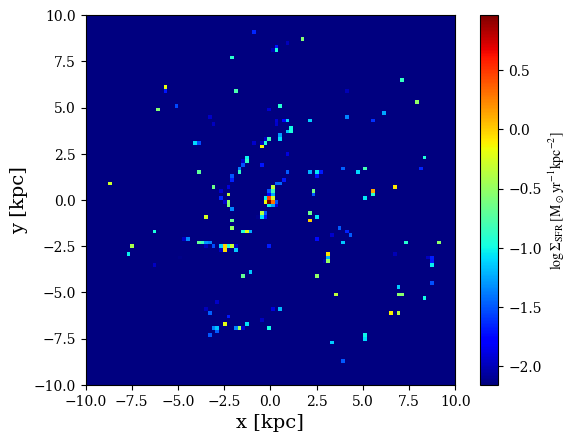

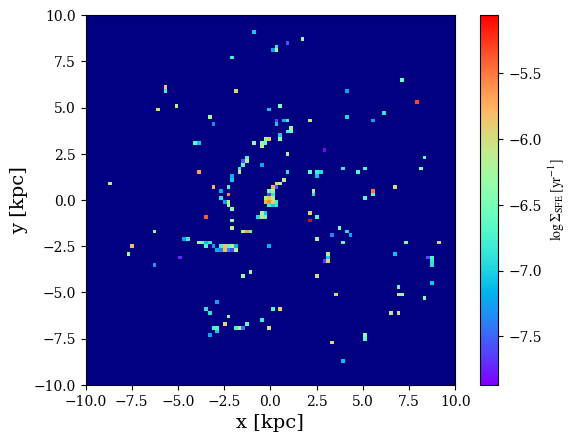

In [13]:
#A very inefficient, very old version of code that 
#should find and plot star formation in the disk over a period of [dt_age]Myr i.e. 100Myr
AGE_LIM = pynbody.units.Unit('10 Myr')
R_LIM   = pynbody.units.Unit('10 kpc')
Z_LIM   = pynbody.units.Unit('3 kpc')
T_DELAY = pynbody.units.Unit('0 Myr')  #Ignore this time-frame of SF in past
t_off = 0
t_form = s.star['tform'].in_units('Myr') - t_off # * utime/sec2myr

x=s.star['x']
y=s.star['y']
m=s.star['mass'].in_units('Msol')
mg=s.gas['mass'].in_units('Msol')
xg=s.gas['x']
yg=s.gas['y']
h=['z']

L  = 10. #length of the box eg. 10kpc
dx = 0.1 #step size in x
dy = 0.1 #step size in y
nx = int(L/dx) #number of steps in x
ny = int(L/dy) #number of steps in y
dt_age     = AGE_LIM.in_units('Myr') 
max_height = Z_LIM.in_units('kpc') 

Mbin = np.zeros((nx,ny))#mass array
Mgbin = np.zeros((nx,ny))#mass array
xbin = np.linspace(-L,L,nx)
ybin = np.linspace(-L,L,ny)
area = np.zeros((nx,ny)) #area array
sfrbin = np.zeros((nx,ny)) #SFR array
logsfrbin = np.zeros((nx,ny)) #logSFR array

t1 = t_now-T_DELAY.in_units('Myr')-dt_age
t2 = t_now-T_DELAY.in_units('Myr')

selage = (t_form>=t1) & (t_form<=t2)
young_m = s.star['mass'][selage]
young_x  = s.star['x'][selage]
young_y  = s.star['y'][selage]
young_h =  np.abs(s.star['z'][selage])
sfr=young_m/(dt_age*1e6)

i=0
j=0
while i<nx:
    j=0
    while j<ny:
        x1 = xbin[i]
        x2 = x1+dx
        y1 = ybin[j]
        y2 = y1+dy
        selgrid =  (young_x>x1) & (young_x<x2) & (young_y>y1) & (young_y<y2) & (young_h<max_height)
        Mbin[i,j] = np.sum(young_m[selgrid])
        area[i,j]  = dx*dy
        sfrbin[i,j] = Mbin[i,j]/area[i,j]/(dt_age*1e6)
        logsfrbin[i,j] = np.log10(sfrbin[i,j])
        j+=1
    i+=1 
ii=0
jj=0
while ii<nx:
    jj=0
    while jj<ny:
        x1 = xbin[ii]
        x2 = x1+dx
        y1 = ybin[jj]
        y2 = y1+dy
        selgrid =  (xg>x1) & (xg<x2) & (yg>y1) & (yg<y2) 
        Mgbin[ii,jj] = np.sum(mg[selgrid])
        jj+=1
    ii+=1     
    
sfebin=sfrbin/Mgbin
logsfebin=np.log10(sfebin)
    
plt.imshow(np.fliplr(np.rot90(logsfrbin,k=3)),origin='lower',extent=(-L,L,-L,L),cmap='jet')
#plt.clim(-2.5,2.5)
plt.colorbar(orientation="vertical", label="$\log\Sigma_{\\rm SFR}\;{\\rm [M_\\odot yr^{-1} kpc^{-2}]}$")
ax=plt.gca()
ax.set_facecolor((0,0,0.5,1))
plt.xlabel('x [kpc]', fontsize=14)
plt.ylabel('y [kpc]', fontsize=14)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()
#plt.savefig('SFRPrj2_'+str(dno)) 

plt.imshow(np.fliplr(np.rot90(logsfebin,k=3)),origin='lower',extent=(-L,L,-L,L),cmap='rainbow')
#plt.clim(-2.5,2.5)
plt.colorbar(orientation="vertical", label="$\log\Sigma_{\\rm SFE}\;{\\rm [yr^{-1}]}$")
ax=plt.gca()
ax.set_facecolor((0,0,0.5,1))
plt.xlabel('x [kpc]', fontsize=14)
plt.ylabel('y [kpc]', fontsize=14)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()
#plt.savefig('SFEPrj2_'+str(dno)) 

In [14]:
#If you ever need to check whether your file is reading the units correctly...
#Try to check what units it thinks the gas mass is in...
#Then, print the gas mass array...
#Our gas mass should be on the order of ~1000Msun, if it is not...
#first check there is a .param file in your working directory, this should fix it.
#if not, cry. 

print(s.gas['mass'].units) #you can select any loadable or derivable key and replace 'mass' with 
print(s.gas['mass']) # that key instead to either call the array or the string that defines its units

Msol
[1280.84545898 1160.73791504 1128.53173828 ...  694.27850342  694.362854
  694.29779053]


999.9635577714558


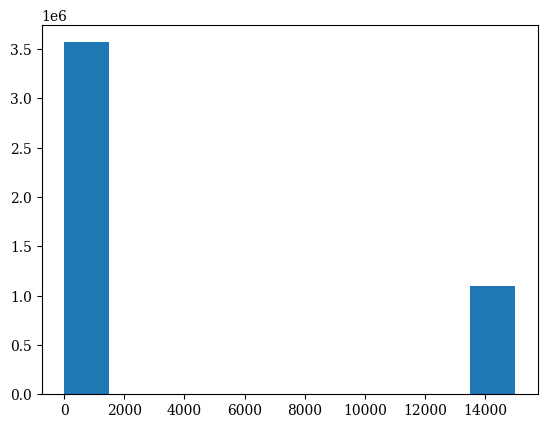

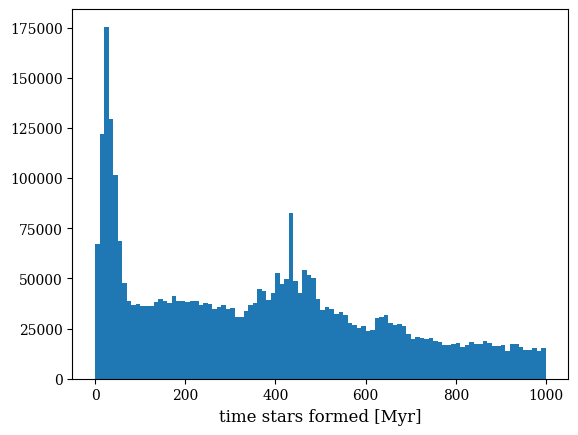

In [17]:
#evidence that there are two different stellar populations
#we set the IC tform as reaaaaaallly old, whereas new stars form from the gas so tform <= time_now
print(t_now)
plt.hist(s.s['tform'].in_units('Myr'))
plt.show()
plt.hist(s.s['tform'].in_units('Myr'), bins=100, range=(0, t_now)) #to see just new stars distribution
plt.xlabel('time stars formed [Myr]', fontsize=12)
plt.show()

In [17]:
# Some code to save generally useful things as .txt files if you want
#comment out the np.savetxt lines for things you don't want to save...
# Note: saves in the code working directory not where you called the snapshot from, need to move. 
# Stellar position, mass and age information. Remember age = tnow-tform
Young_Star_names = np.reshape(["snapshot","x", "y", "z", "mass", "tform"],(1,6))
Young_Star_units = np.reshape(["Myr","kpc", "kpc", "kpc", "$M_{\odot}$", "Myr"],(1,6))
Young_G_names = np.reshape(["snapshot","x", "y", "z", "mass"],(1,5))
Young_G_units = np.reshape(["Myr","kpc", "kpc", "kpc", "$M_{\odot}$"],(1,5))
Table_timeS=np.reshape(np.ones((1,len(s.star['x'])))*int(dno),(len(s.star['x'])))
#Table_timeG=np.reshape(np.ones((1,len(s.gas['x'])))*int(dno),(len(s.gas['x'])))
print (Table_timeS[0])
s_forSFR = np.column_stack((Table_timeS,s.star['x'].in_units('kpc'),s.star['y'].in_units('kpc'),s.star['z'].in_units('kpc'),s.star['mass'],s.star['tform'].in_units('Myr')))
gas_forSFR = np.column_stack((Table_timeG,s.gas['x'].in_units('kpc'),s.gas['y'].in_units('kpc'),s.gas['z'].in_units('kpc'),s.gas['mass']))
Sout = np.concatenate((Young_Star_names,Young_Star_units,s_forSFR))
Gas_out = np.concatenate((Young_G_names,Young_G_units,gas_forSFR))
np.savetxt("AllStars_"+str(dno)+".txt",Sout,fmt="%s")
np.savetxt("AllGas_"+str(dno)+".txt",Gas_out,fmt="%s")

# Stellar velocities for (x,y,z) and (r,phi,z) co-ordinates
sVel_names = np.reshape(["snapshot","svx", "svy", "svz", "svr", "svphi"],(1,6))
Vel_units = np.reshape(["Myr","km/s", "km/s", "km/s", "km/s", "km/s"],(1,6))
Table_timeS=np.reshape(np.ones((1,len(s.star['x'])))*int(dno),(len(s.star['x'])))
#print Table_timeS[0]
s_vel = np.column_stack((Table_timeS,s.star['vx'].in_units('km s^-1'),s.star['vy'].in_units('km s^-1'),s.star['vz'].in_units('km s^-1'),s.star['vr'].in_units('km s^-1'),s.star['vphi'].in_units('km s^-1')))
Svout = np.concatenate((sVel_names,Vel_units,s_vel))
np.savetxt("AllStarsV_"+str(dno)+".txt",Svout,fmt="%s")